# Notes

- [mne.io.RawArray.plot](https://mne.tools/stable/generated/mne.io.RawArray.html#mne.io.RawArray.plot)




Creating RawArray with float64 data, n_channels=1, n_times=48760
    Range : 0 ... 48759 =      0.000 ...   243.795 secs
Ready.


<ipython-input-141-bbd42c1bbf32>:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4.5, 3))


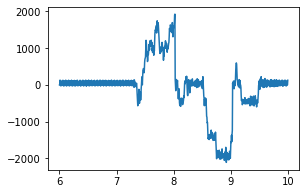

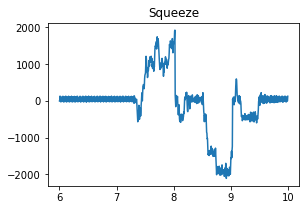

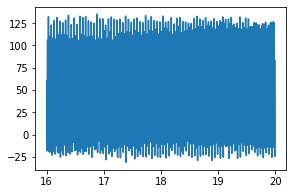

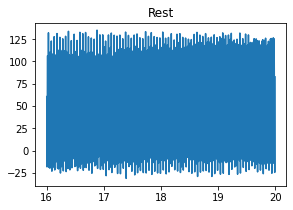

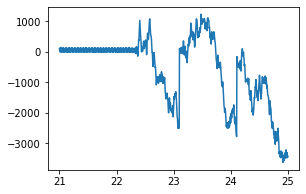

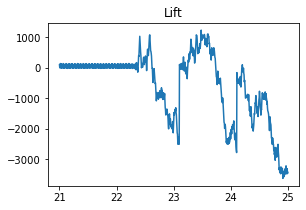

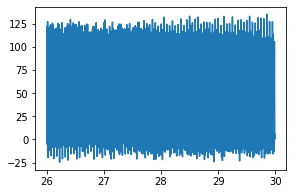

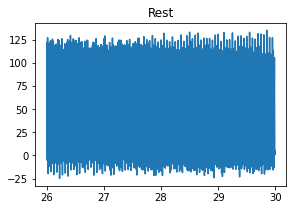

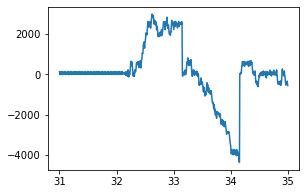

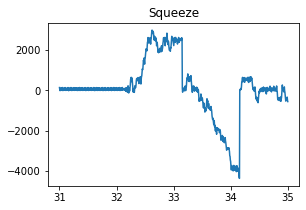

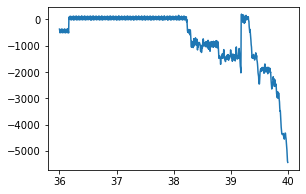

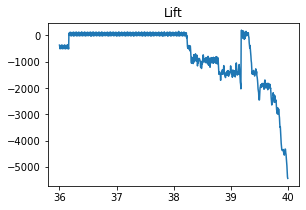

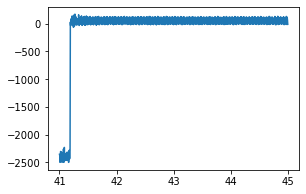

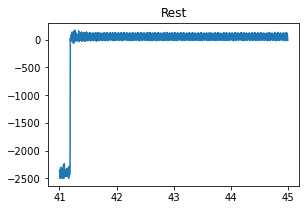

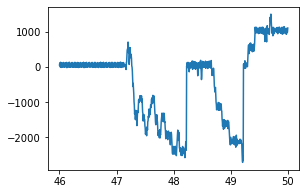

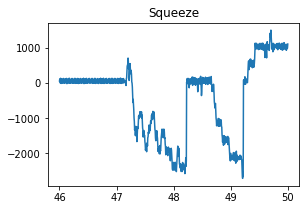

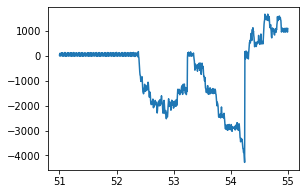

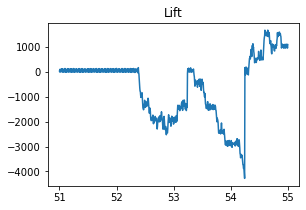

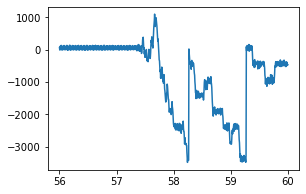

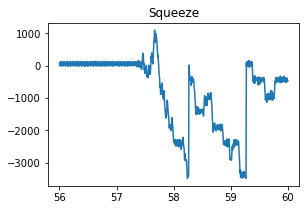

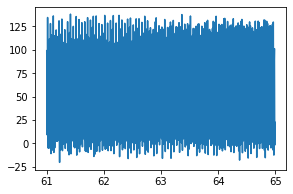

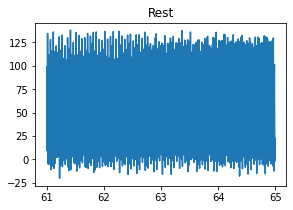

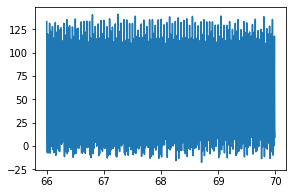

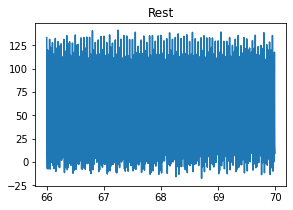

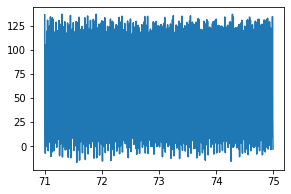

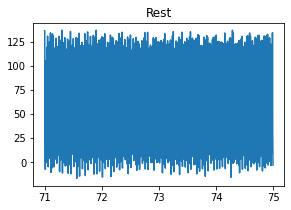

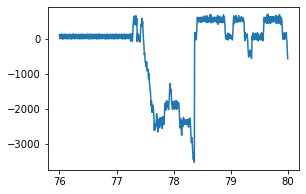

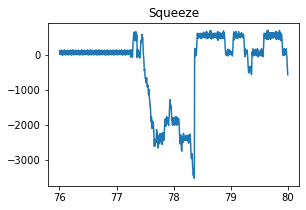

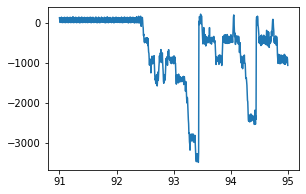

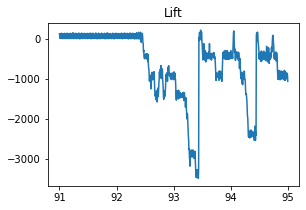

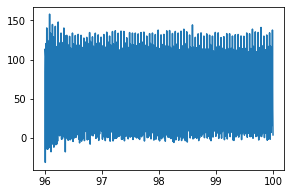

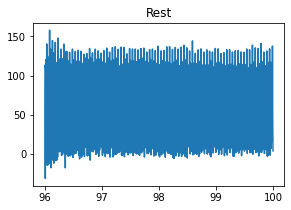

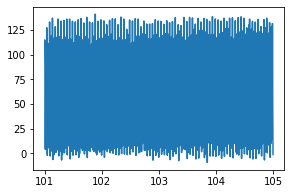

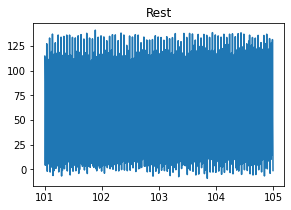

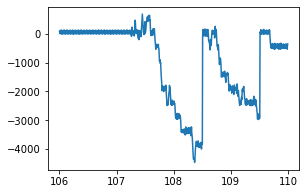

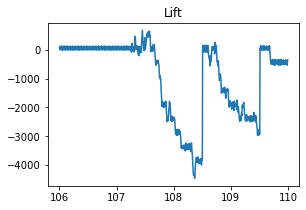

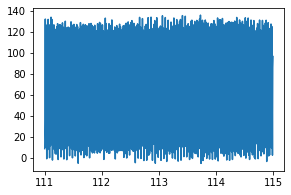

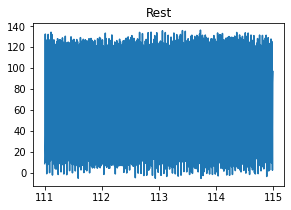

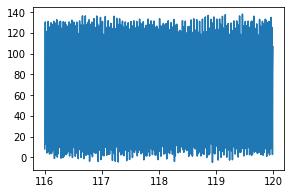

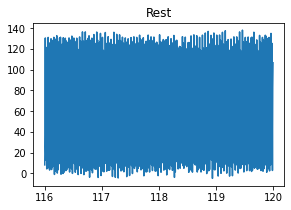

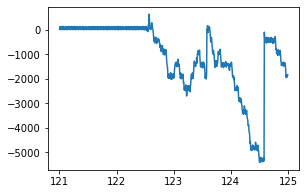

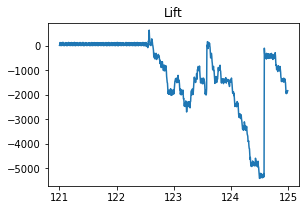

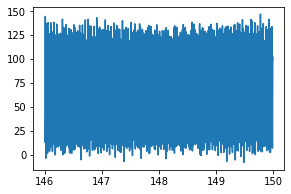

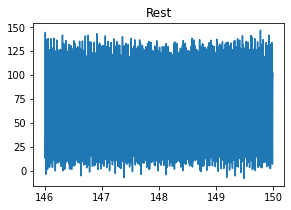

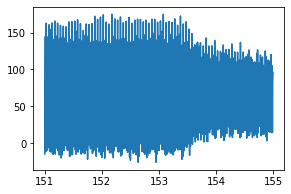

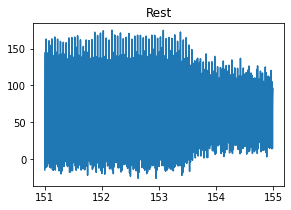

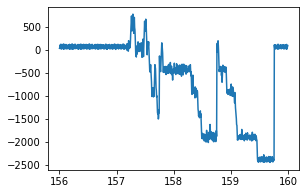

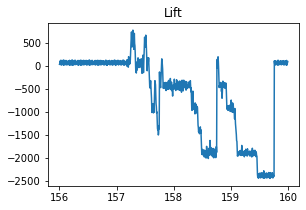

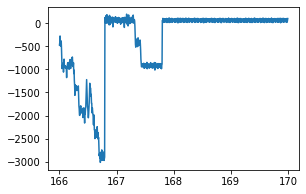

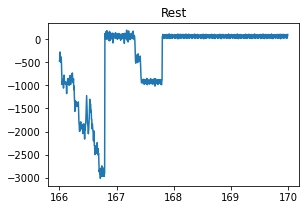

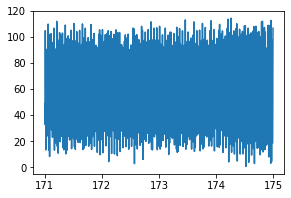

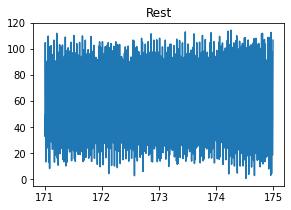

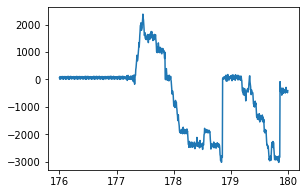

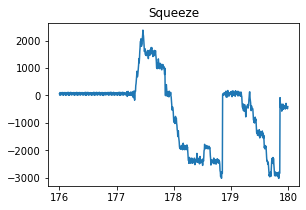

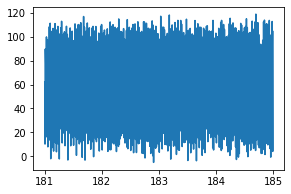

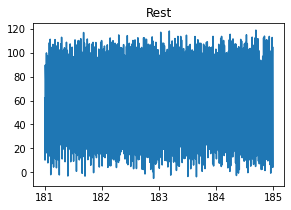

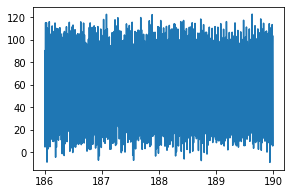

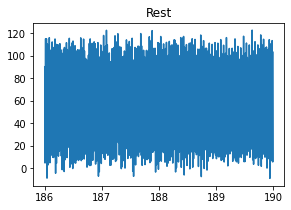

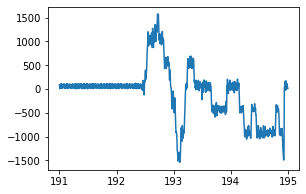

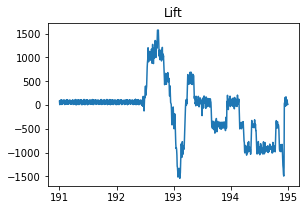

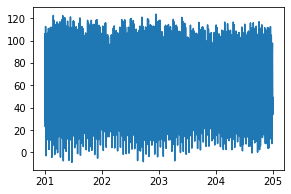

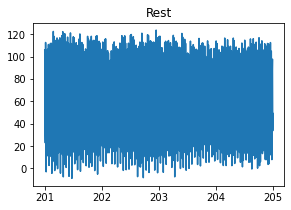

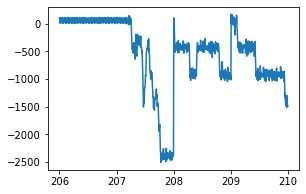

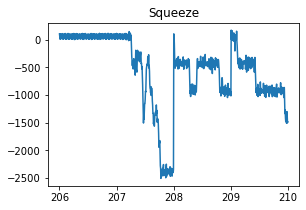

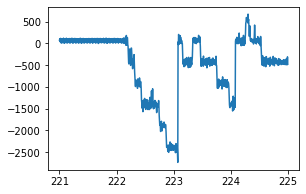

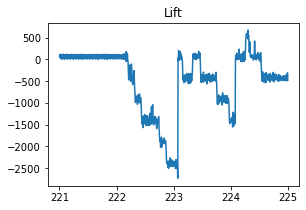

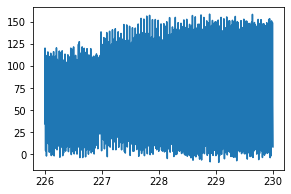

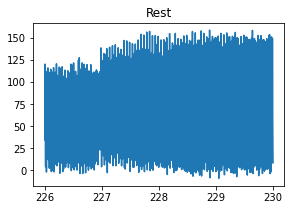

In [141]:
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


class PhysioLearn:
    def __init__(self, num_channels, channel_type, eventFile=None, eventMapping=None):
        self.currentFileDf = []
        self.currentFile = None
        self.channels = num_channels
        self.channelTypes = [channel_type] * num_channels
        self.channelNames = [str(n) for n in range(num_channels)]
        self.sfreq = 200
        self.mneFactor = 1000000 # account for unit conversion if necessary
        self.markerChannel = 14
        self.eventMapping = eventMapping
        self.events = mne.read_events(eventFile)
        self.date = datetime.now().strftime("%H:%M:%S")
        self.eventsEmbeded = []
        self.raw = None
        self.info = mne.create_info(
            ch_names=self.channelNames, sfreq=self.sfreq, ch_types=self.channelTypes)

    def createEvents(self):
        i = 0
        array = []
        for sample in self.currentFileDf[self.markerChannel]:
            i = i + 1
            if sample != 0.0:
                array.append([i, 0, int(sample)])
        self.eventsEmbeded = np.array(array, dtype=int)
        df = pd.DataFrame(data=self.eventsEmbeded).to_csv(f'data/{self.date}_events-gen-eve.txt', sep=" ", index=None, header=None)

        

    def readFile(self, location):
        self.currentFile = DataFilter.read_file(location)
        self.currentFileDf = pd.DataFrame(np.transpose(self.currentFile))
        res = self.currentFile[1:2] / self.mneFactor
        self.raw = mne.io.RawArray(res, self.info)
        

    def getDataDuration(self):
        #seconds
        return len(self.currentFile[0]) / self.sfreq
         
    def createPlots(self):
        duration = round(self.getDataDuration() - 2)
        window_size = duration / 4
        if len(self.eventsEmbeded) == 0:
            events = self.events
        else:
            events = self.eventsEmbeded
        for i in range(4):
            start = i * window_size
            self.raw.plot(events=events, start=start, duration=window_size,
                 event_id=self.eventMapping)
            
    def getEvents(self):
        if len(self.eventsEmbeded) == 0:
            events = self.events
        else:
            events = self.eventsEmbeded
        
        return events
        
        
    def plotEvents(self, eventDuration):
        events = self.getEvents()
        e_map = {100: 'Rest', 99: 'Lift', 98: 'Squeeze' }
        for event in events:
            data, times = self.getEpoch(int(event[0] / self.sfreq), eventDuration)
            fig, ax = plt.subplots(figsize=(4.5, 3))
            title = e_map[event[2]]
            plt.title(title)
            ax.plot(times, data[0] * self.mneFactor)
            #plt.savefig('raw.png')
            
    def getEpoch(self, start, eventDuration):
        start = start * self.sfreq
        duration = eventDuration * self.sfreq
        stop = start + duration
        data, times = self.raw.get_data(return_times=True, start=start, stop=stop)
        fig, ax = plt.subplots(figsize=(4.5, 3))
        ax.plot(times, data[0] * self.mneFactor)
        return data, times

    def start(self):
        self.readFile("data/trial1.csv")
        #self.createEvents()
        #self.createPlots() 
        self.plotEvents(4)
        #data, times = self.getEpoch(0, 10)
        
def main():  
    event_mapping = {'Rest': 100, 'Lift': 99, 'Squeeze': 98}
    learn = PhysioLearn(1, "emg", "data/events-gen-cleaned-eve.txt", event_mapping)
    learn.start()
    
main()